In [ ]:
pip install osmnx
#can do a conda forge as well

In [4]:
import networkx as nx
import osmnx as ox

In [26]:
# download/model a street network for some city then visualize it
#basic graphing capabilities
G = ox.graph_from_place("Richmond, Virginia, USA", network_type="drive")

In [10]:
# get the city and not the county as a gdf
rva = ox.geocode_to_gdf(
    {
        "city": "Richmond",
        "state": "Virginia",
        "country": "USA",
    }
)

In [31]:
#consolodate intersections
ints = ox.consolidate_intersections(G, rebuild_graph=False, tolerance=300, dead_ends=False)
len(ints)

c:\Users\egreenwell\anaconda3\Lib\site-packages\osmnx\simplification.py:585: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
c:\Users\egreenwell\anaconda3\Lib\site-packages\osmnx\simplification.py:549: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return _merge_nodes_geometric(G, tolerance).centroid


1

In [32]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G, rebuild_graph=True, tolerance=300, dead_ends=False)
len(G2)

c:\Users\egreenwell\anaconda3\Lib\site-packages\osmnx\simplification.py:585: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = gdf_nodes.buffer(tolerance).union_all()
c:\Users\egreenwell\anaconda3\Lib\site-packages\osmnx\simplification.py:640: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid


1

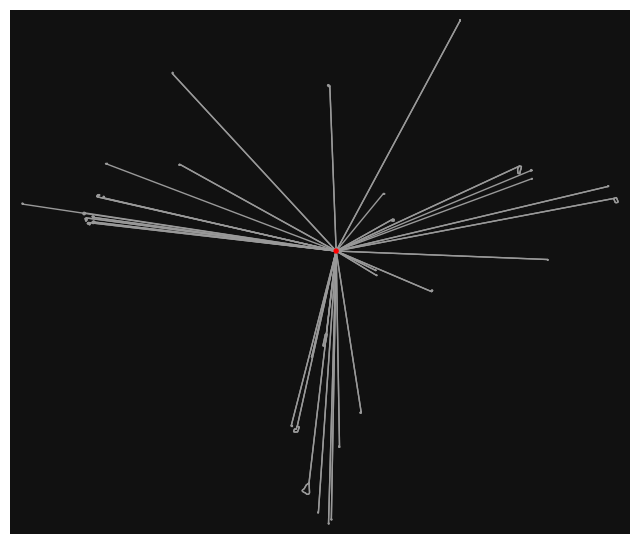

In [33]:
fig, ax = ox.plot_graph(G2, node_color="r")

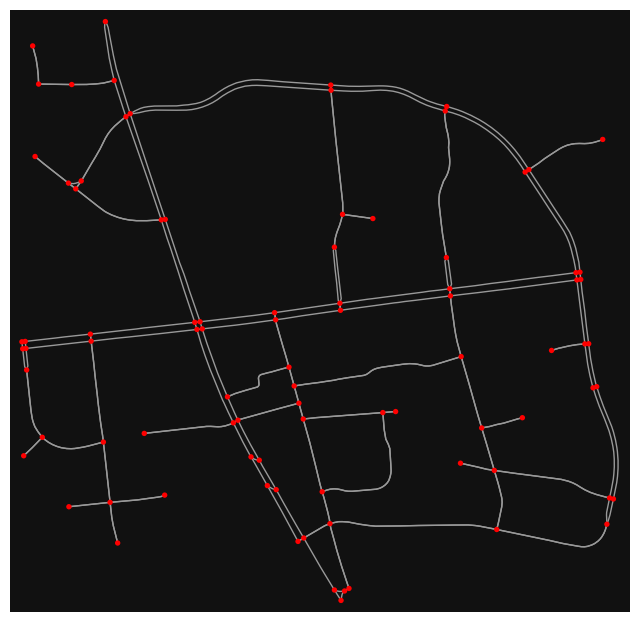

In [35]:
# get a street network and plot it with all edge intersections
point = 37.505860, -77.606542
G = ox.graph_from_point(point, network_type="drive", dist=1000)
fig, ax = ox.plot_graph(G, node_color="r")

In [36]:
# get a GeoSeries of consolidated intersections
G_proj = ox.project_graph(G)
ints = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
len(ints)

52

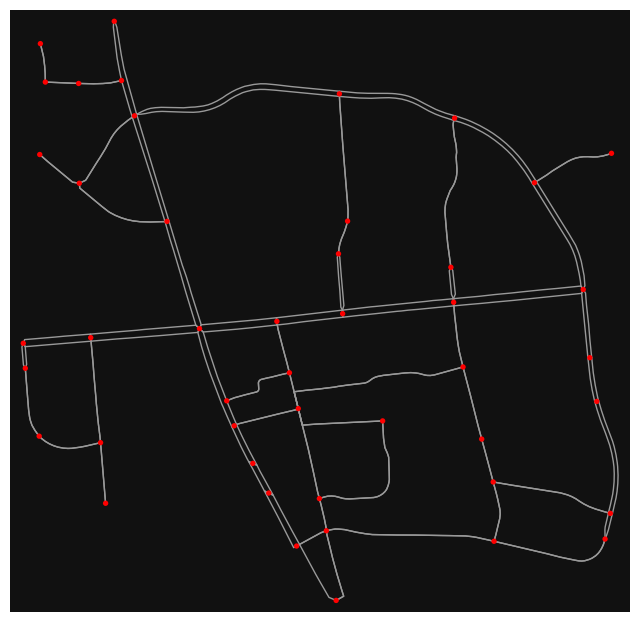

In [37]:
# consolidate intersections and rebuild graph topology
# this reconnects edge geometries to the new consolidated nodes
G2 = ox.consolidate_intersections(G_proj, rebuild_graph=True, tolerance=30, dead_ends=False)
len(G2)

fig, ax = ox.plot_graph(G2, node_color="r")

Isochrones Test

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

In [50]:
# configure the place, network type, trip times, and travel speed
place = {"city": "Richmond", "state": "Virginia", "neighborhood": "Manchester"}
network_type = "walk"
trip_times = [5, 10, 15, 20, 25]  # in minutes
travel_speed = 4.5  # walking speed in km/hour

In [56]:
location_point = (37.52447983556867, -77.43811079936494)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type=network_type)

In [ ]:
# download the street network
#G = ox.graph_from_place(place, network_type=network_type)

In [57]:
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2259039439.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  x, y = gdf_nodes["geometry"].unary_union.centroid.xy


In [58]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [59]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0)

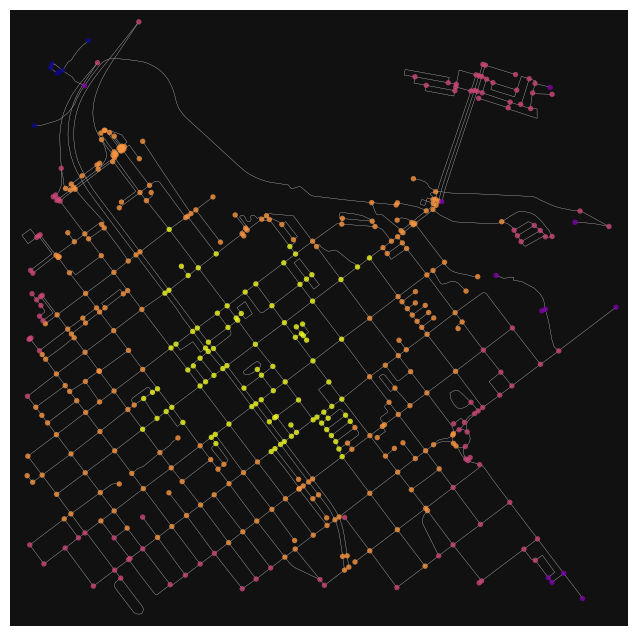

In [60]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

In [61]:
# make the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2936926019.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2936926019.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2936926019.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2936926019.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
C:\Users\egreenwell\AppData\Loca

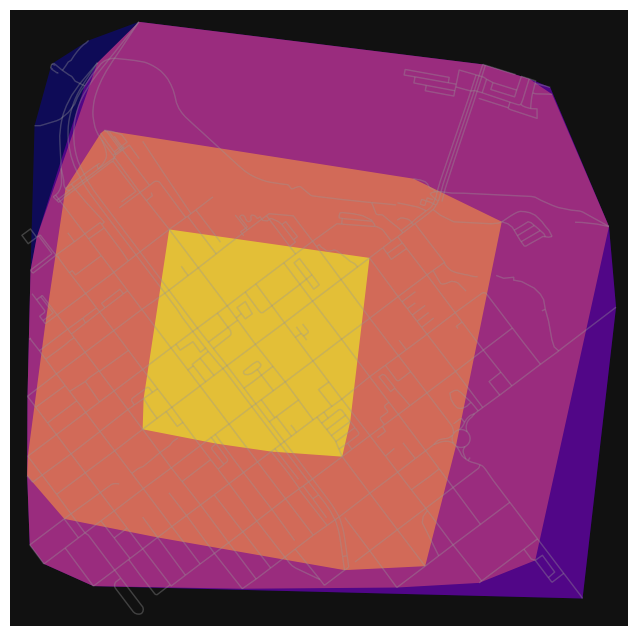

In [62]:

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2863658293.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2863658293.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2863658293.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2863658293.py:20: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  new_iso = gpd.GeoSeries(all_gs).unary_union
C:\Users\egreenwell\AppData\Local\Temp\ipykernel_71856\2863658293.py:20: DeprecationWarning: The 'unary_union' attribute

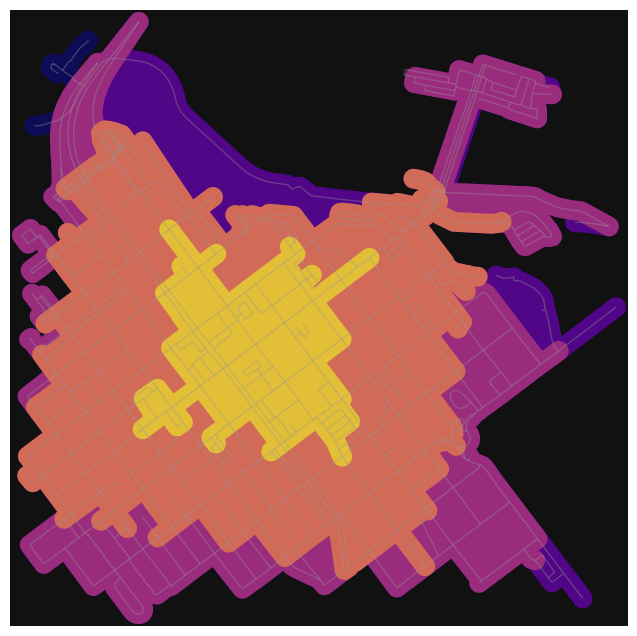

In [63]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


# make the isochrone polygons
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
gdf = gpd.GeoDataFrame(geometry=isochrone_polys)

# plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
gdf.plot(ax=ax, color=iso_colors, ec="none", alpha=0.6, zorder=-1)
plt.show()

Streets Orientations

In [68]:
import numpy as np
weight_by_length = False

In [82]:
# define the study sites as label : query
places = {
    'Richmond': 'Richmond, Virginia, USA',
    # 'Atlanta'       : 'Atlanta, Georgia, USA',
    # 'Boston'        : 'Boston, MA, USA',
    #"Buffalo": "Buffalo, NY, USA",
    # 'Charlotte'     : 'Charlotte, NC, USA',
    # 'Chicago'       : 'Chicago, IL, USA',
    #"Cleveland": "Cleveland, OH, USA",
    # 'Dallas'        : 'Dallas, TX, USA',
    # 'Houston'       : 'Houston, TX, USA',
    # 'Denver'        : 'Denver, CO, USA',
    # 'Detroit'       : 'Detroit, MI, USA',
    # 'Las Vegas'     : 'Las Vegas, NV, USA',
    # 'Los Angeles'   : {'city':'Los Angeles', 'state':'CA', 'country':'USA'},
    # 'Manhattan'     : 'Manhattan, NYC, NY, USA',
    # "Miami": "Miami, FL, USA",
    #"Minneapolis": "Minneapolis, MN, USA",
    # 'Orlando'       : 'Orlando, FL, USA',
    # 'Philadelphia'  : 'Philadelphia, PA, USA',
    # 'Phoenix'       : 'Phoenix, AZ, USA',
    # 'Portland'      : 'Portland, OR, USA',
    # 'Sacramento'    : 'Sacramento, CA, USA',
    # "San Francisco": {"city": "San Francisco", "state": "CA", "country": "USA"},
    # 'Seattle'       : 'Seattle, WA, USA',
    # 'St Louis'      : 'St. Louis, MO, USA',
    # 'Tampa'         : 'Tampa, FL, USA',
    "Washington": "District of Columbia, USA",
}

In [83]:
# verify OSMnx geocodes each query to what you expect (i.e., a [multi]polygon geometry)
gdf = ox.geocode_to_gdf(list(places.values()))
gdf

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((-77.60117 37.54516, -77.60077 37.544...",-77.601173,37.446731,-77.385303,37.602810,321708065,relation,3864712,37.538509,-77.434280,boundary,administrative,12,0.667930,city,Richmond,"Richmond, Virginia, United States"
1,"POLYGON ((-77.11979 38.93435, -77.11977 38.934...",-77.119795,38.791630,-76.909366,38.995968,319551174,relation,162069,38.893847,-76.988043,boundary,administrative,8,0.568156,district,District of Columbia,"District of Columbia, United States"


2024-12-03 13:42:35 Richmond
2024-12-03 13:42:44 Washington


FileNotFoundError: [Errno 2] No such file or directory: 'images/street-orientations.png'

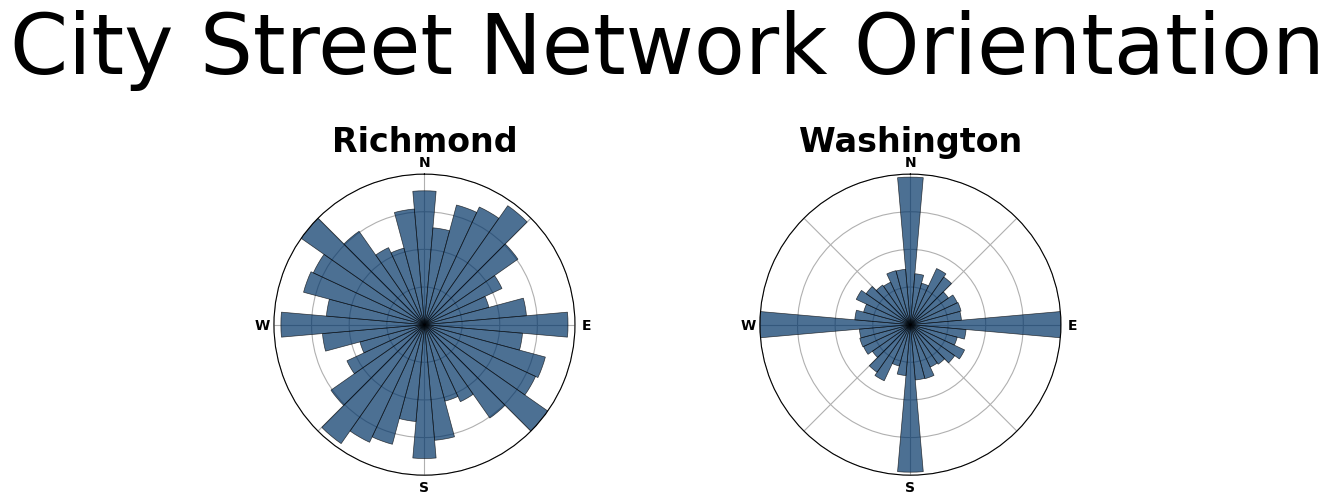

In [84]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={"projection": "polar"})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    print(ox.utils.ts(), place)

    # get undirected graphs with edge bearing attributes
    G = ox.graph_from_place(place, network_type="drive")
    Gu = ox.add_edge_bearings(ox.convert.to_undirected(G))
    fig, ax = ox.plot_orientation(Gu, ax=ax, title=place, area=True)

# add figure title and save image
suptitle_font = {
    "family": "DejaVu Sans",
    "fontsize": 60,
    "fontweight": "normal",
    "y": 1,
}
fig.suptitle("City Street Network Orientation", **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig("images/street-orientations.png", facecolor="w", dpi=100, bbox_inches="tight")
plt.close()

Road Grid Orientation by Road Type